<a href="https://colab.research.google.com/github/Shravanya178/MLDL_EXPS/blob/main/MLDL_EXP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, RocCurveDisplay


In [5]:
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv("/content/CEEW - IRES Data.csv")

df.shape


Saving CEEW - IRES Data.csv to CEEW - IRES Data (1).csv


/tmp/ipython-input-2454589002.py:5: DtypeWarning: Columns (6,15,22,46,84,98,163,172,179,269,279,330,358,384,418,441,458,474,497) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/CEEW - IRES Data.csv")


(14851, 517)

In [6]:
predictor_cols = [
    "state_abbv",
    "q201_resp_gender",
    "q202_resp_age",
    "q208_priminc_earner_edu",
    "q213_no_members",
    "q216_house_pucca_kachha",
    "q220_own_house_yn",
]

predictor_cols = [c for c in predictor_cols if c in df.columns]
predictor_cols


['state_abbv',
 'q201_resp_gender',
 'q202_resp_age',
 'q208_priminc_earner_edu',
 'q213_no_members',
 'q216_house_pucca_kachha',
 'q220_own_house_yn']

In [7]:
log_target = "q320_c_solar_mini_grid_yn"

log_df = df[predictor_cols + [log_target]].dropna().copy()
log_df[log_target] = log_df[log_target].apply(lambda x: 1 if x == 1 else 0)

X = log_df[predictor_cols]
y = log_df[log_target]

num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

pipe = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

param_grid = {"model__C": [0.01, 0.1, 1, 10]}

grid_log = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc")
grid_log.fit(X_train, y_train)

best_log = grid_log.best_estimator_
grid_log.best_params_


{'model__C': 10}

In [10]:
pred = best_log.predict(X_test)
prob = best_log.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, prob))
print(classification_report(y_test, pred))


Accuracy: 0.994614607876136
ROC AUC: 0.8730647208121828
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2955
           1       0.00      0.00      0.00        16

    accuracy                           0.99      2971
   macro avg       0.50      0.50      0.50      2971
weighted avg       0.99      0.99      0.99      2971



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


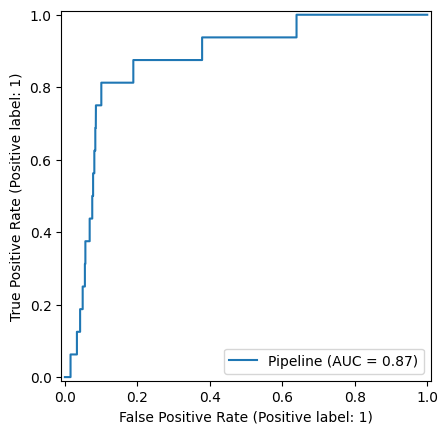

In [11]:
RocCurveDisplay.from_estimator(best_log, X_test, y_test)
plt.show()


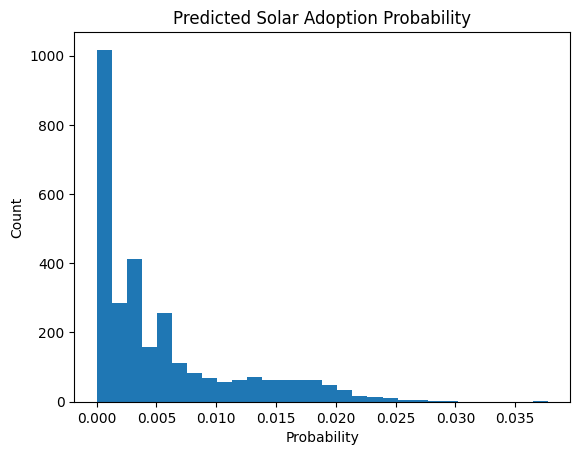

In [12]:
plt.hist(prob, bins=30)
plt.title("Predicted Solar Adoption Probability")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()


In [13]:
lin_target = "avg_monthly_bill"

lin_df = df[predictor_cols + [lin_target]].dropna().copy()

X = lin_df[predictor_cols]
y = lin_df[lin_target]

num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [15]:
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

pipe = Pipeline([
    ("prep", preprocess),
    ("model", Ridge())
])

param_grid = {"model__alpha": [0.1, 1, 10, 100]}

grid_lin = GridSearchCV(pipe, param_grid, cv=5, scoring="r2")
grid_lin.fit(X_train, y_train)

best_lin = grid_lin.best_estimator_
grid_lin.best_params_


{'model__alpha': 1}

In [16]:
pred = best_lin.predict(X_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))
print("R2:", r2_score(y_test, pred))


RMSE: 601.8757014494711
R2: 0.2920731049344363


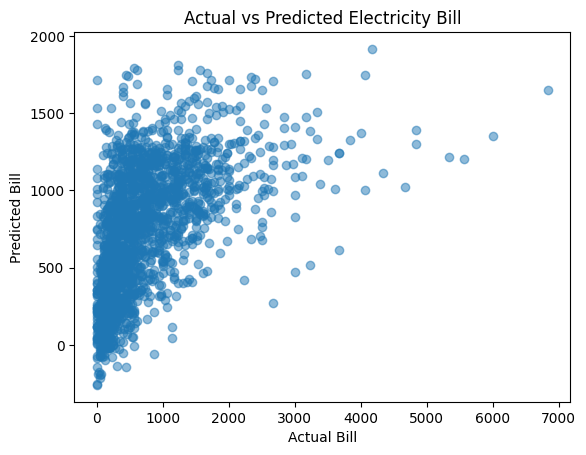

In [17]:
plt.scatter(y_test, pred, alpha=0.5)
plt.xlabel("Actual Bill")
plt.ylabel("Predicted Bill")
plt.title("Actual vs Predicted Electricity Bill")
plt.show()


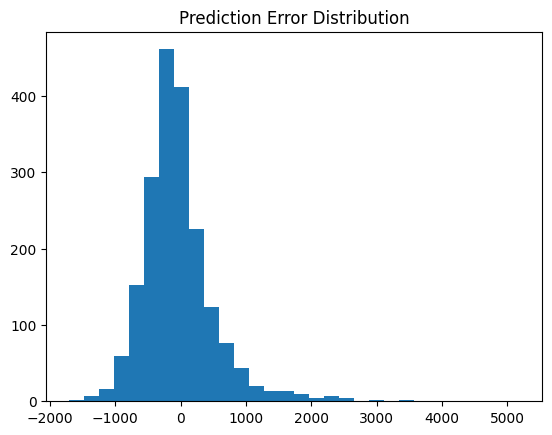

In [18]:
errors = y_test - pred
plt.hist(errors, bins=30)
plt.title("Prediction Error Distribution")
plt.show()
